# TP Module 9 : Optimisation des modèles

But de l'optimisation des modèles :

- Réduire la taille du modèle.
- Accélérer le temps d'inférence.
- Réduire la consommation énergétique du modèle.


Quelles sont les différentes façon d'optimiser une modèle ?

- Réduire sa précision numérique.
  - Les paramètres et fonctions d'activations d'un modèle sont le plus souvent représentés en `float32`. **Quantification**
- Toutes les opérations du graphe d'un modèle sont elles nécéssaires durant l'inférence ? **Fusion des couches**
- Tous les paramètres contribuent ils à la performance du modèle ? **Pruning**
- Améliorer les allers-retours entre GPU et CPU.

- Ref
  - https://colab.research.google.com/github/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/A_tale_of_quantization.ipynb#scrollTo=HHZ-SsZU5VAW
  - https://colab.research.google.com/github/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/Model_Pruning_in_Deep_Learning_with_tfmot.ipynb#scrollTo=cEDnyetVLTcM
  - https://colab.research.google.com/github/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/Custom_Image_Classification_EdgeTPU.ipynb#scrollTo=57GUpImAP7KC

- TF Lite

  - https://www.tensorflow.org/lite/performance/post_training_quantization

  - https://www.tensorflow.org/lite/performance/post_training_quant

  - https://www.tensorflow.org/lite/performance/post_training_quantization#dynamic_range_quantization

  - https://www.tensorflow.org/lite/performance/best_practices#profile_your_application_with_platform_specific_tools

  - https://www.tensorflow.org/lite/performance/post_training_integer_quant

- Model Optimization/Pruning

  - https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras#overview

  - https://www.tensorflow.org/model_optimization/api_docs/python/tfmot

  - https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/sparsity/keras/ConstantSparsity

   -https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/sparsity/keras/PruningSchedule

  - https://www.tensorflow.org/model_optimization/guide/quantization/training_comprehensive_guide

   -https://www.tensorflow.org/model_optimization/guide/pruning/comprehensive_guide#prune_whole_model_sequential_and_functional

 - https://www.tensorflow.org/model_optimization/guide/quantization/training

 - https://tensorflow.google.cn/model_optimization/guide/pruning/pruning_with_keras

- Save/Load

  - https://www.tensorflow.org/tutorials/keras/save_and_load













## **Import libs**

In [ ]:
import tensorflow as tf
from tensorflow import keras

print(f'tf : {tf.__version__}')
print(f'keras : {keras.__version__}')

import pandas as pd
import numpy as np
import random
import os
import datetime

# freeze de l'aléatoire, pour avoir des expériences reproductibles.
RANDOM_SEED = 42

os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(RANDOM_SEED)

tf : 2.3.0
keras : 2.4.0


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import shutil
import time
import cv2

In [ ]:
!nvidia-smi

Thu Aug 27 20:42:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
comp = pd.DataFrame()
comp['model'] = []
comp['précision'] = []

## Import du dataset

In [ ]:
# Gather Flowers-17 dataset
data_root = tf.keras.utils.get_file(
  "/content/flower_photos", "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
   untar=True)

In [ ]:
# Untar the dataset
!tar -xvf flower_photos.tar.gz

flower_photos/
flower_photos/roses/
flower_photos/roses/14810868100_87eb739f26_m.jpg
flower_photos/roses/1446090416_f0cad5fde4.jpg
flower_photos/roses/15319767030_e6c5602a77_m.jpg
flower_photos/roses/15032112248_30c5284e54_n.jpg
flower_photos/roses/7211616670_2d49ecb3a5_m.jpg
flower_photos/roses/15674450867_0ced942941_n.jpg
flower_photos/roses/17158274118_00ec99a23c.jpg
flower_photos/roses/14019883858_e5d2a0ec10_n.jpg
flower_photos/roses/8035908422_87220425d2_n.jpg
flower_photos/roses/14747962886_2bff6bb323_m.jpg
flower_photos/roses/4356781875_92c5cd93c0.jpg
flower_photos/roses/8524505546_b242bd4928_n.jpg
flower_photos/roses/9406573080_60eab9278e_n.jpg
flower_photos/roses/6039330368_c30ed224c4_m.jpg
flower_photos/roses/14414100710_753a36fce9.jpg
flower_photos/roses/3292434691_392071d702_n.jpg
flower_photos/roses/5273722065_c85d8543c2_m.jpg
flower_photos/roses/2215318403_06eb99176a.jpg
flower_photos/roses/172311368_49412f881b.jpg
flower_photos/roses/15255964454_0a64eb67fa.jpg
flower_pho

In [ ]:
# All the paths of the flowers
ALL_IMG_PATHS = list(paths.list_images("flower_photos"))
ALL_IMG_PATHS[:5]

['flower_photos/tulips/8904780994_8867d64155_n.jpg',
 'flower_photos/tulips/10094731133_94a942463c.jpg',
 'flower_photos/tulips/16594995743_ce72c61201_n.jpg',
 'flower_photos/tulips/6187740107_9813ccc41e.jpg',
 'flower_photos/tulips/8712282563_3819afb7bc.jpg']

### Visualisation

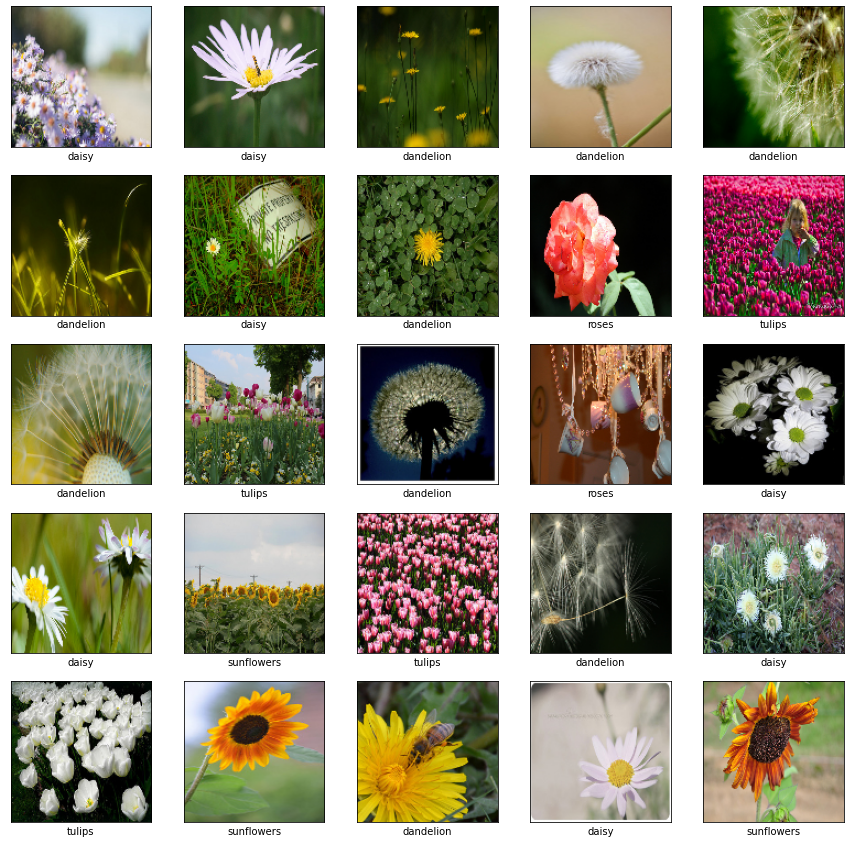

In [ ]:
# Visualize images
plt.figure(figsize=(15,15))
for i in range(25):
    image_path = np.random.choice(ALL_IMG_PATHS)
    image = plt.imread(image_path)
    image = cv2.resize(image, (128, 128))
    # you might want to verify the labels before 
    # you put this to use
    label = image_path.split("/")[1]
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(image)
    plt.xlabel(label)
plt.show()

### Train, val, test datasets

In [ ]:
flower_train, flower_val = train_test_split(ALL_IMG_PATHS, test_size=0.20, random_state=RANDOM_SEED)
flower_test, flower_val = train_test_split(flower_val, test_size=0.5, random_state=RANDOM_SEED)
print(f'images in train : {len(flower_train)}, images in val : {len(flower_val)}, images in test {len(flower_test)}')

images in train : 2936, images in val : 367, images in test 367


In [ ]:
dic = {b'daisy': 0, b'dandelion': 1, b'roses': 2, b'sunflowers': 3, b'tulips': 4}
label_train = [dic[tf.strings.split(filename, '/')[1].numpy()] for filename in flower_train]
label_val = [dic[tf.strings.split(filename, '/')[1].numpy()] for filename in flower_val]
label_test = [dic[tf.strings.split(filename, '/')[1].numpy()] for filename in flower_test]
print(f'labels in train : {len(label_train)}, labels in val : {len(label_val)}, labels in test {len(label_test)}')

labels in train : 2936, labels in val : 367, labels in test 367


In [ ]:
NUM_CLASSES = 5
AUTOTUNE = tf.data.experimental.AUTOTUNE

def parse_image(filename,label):
  # convert the label to one-hot encoding
  label = tf.one_hot(label, NUM_CLASSES)
  
  #decode image
  image = tf.io.read_file(filename)
  #Don't use tf.image.decode_image, or the output shape will be undefined
  image = tf.image.decode_jpeg(image)
  #This will convert to float values in [0, 1]
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [224, 224])
  return image, label
  
def train_preprocess(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)

  return image, label

def create_train_dataset(features, labels, batch=32, repet=1, prefetch=1):
  dataset = tf.data.Dataset.from_tensor_slices((features,labels))
  dataset = dataset.shuffle(len(features), seed=RANDOM_SEED)
  dataset = dataset.repeat(repet)
  dataset = dataset.map(parse_image, num_parallel_calls=AUTOTUNE)
  dataset = dataset.map(train_preprocess, num_parallel_calls=AUTOTUNE)
  dataset = dataset.batch(batch)
  dataset = dataset.prefetch(prefetch)
  return dataset

def create_val_dataset(features, labels, batch=32, repet=1, prefetch=1):
  dataset = tf.data.Dataset.from_tensor_slices((features,labels))
  dataset = dataset.shuffle(len(features), seed=RANDOM_SEED)
  dataset = dataset.repeat(repet)
  dataset = dataset.map(parse_image, num_parallel_calls=AUTOTUNE)
  dataset = dataset.batch(batch)
  dataset = dataset.prefetch(prefetch)
  return dataset

In [ ]:
ds_train = create_train_dataset(flower_train, label_train)
ds_val = create_val_dataset(flower_val, label_val)
ds_test = create_val_dataset(flower_test, label_test)

## Construction du modèle & entraînement du modèle

### Construction

In [ ]:
# Load the MobileNetV2 model but exclude the classification layers
conv_base = MobileNetV2(weights="imagenet", 
                        include_top=False,
                        input_shape=(224, 224, 3))

In [ ]:
def get_training_model():
    # We are fine-tuning the extractor model
    conv_base.trainable = True
    # Construct the head of the model that will be placed on top of the
    # the base model
    class_head = conv_base.output
    class_head = GlobalAveragePooling2D()(class_head)
    class_head = Dense(512, activation="relu")(class_head)
    class_head = Dropout(0.5)(class_head)
    class_head = Dense(5, activation="softmax")(class_head)

    # Create the new model
    classifier = Model(inputs=conv_base.input, outputs=class_head)

    # Compile and return the model
    classifier.compile(loss="categorical_crossentropy", 
                          optimizer="adam",
                          metrics=["accuracy"])

    return classifier

### Entraînement

In [ ]:
# LR schedule configuration
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

In [ ]:
# LR schedule
def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

1e-05 1.0002177807148294e-05


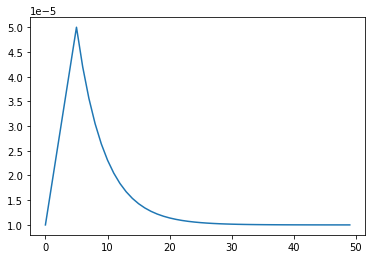

In [ ]:
# How does the LR schedule looks like?
rng = [i for i in range(50)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
print(y[0], y[-1])

In [ ]:
# Train the model
flower_model = get_training_model()
start = time.time()
history = flower_model.fit(ds_train,
                           validation_data=ds_val,
                           epochs=10,
                           callbacks=[lr_callback])
print("Total training time: ",time.time()-start)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/10
92/92 [==============================] - 21s 232ms/step - loss: 1.6581 - accuracy: 0.3195 - val_loss: 1.1938 - val_accuracy: 0.5368

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
Epoch 2/10
92/92 [==============================] - 21s 225ms/step - loss: 1.0207 - accuracy: 0.6039 - val_loss: 0.8238 - val_accuracy: 0.6839

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 3/10
92/92 [==============================] - 21s 227ms/step - loss: 0.6066 - accuracy: 0.7790 - val_loss: 0.5826 - val_accuracy: 0.7902

Epoch 00004: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
Epoch 4/10
92/92 [==============================] - 20s 221ms/step - loss: 0.4566 - accuracy: 0.8389 - val_loss: 0.4539 - val_accuracy: 0.8365

Epoch 00005: LearningRateScheduler reducing learning rate to 4.2000000000000004e-05.
Epoch 5/10
92/9

#### Evaluation

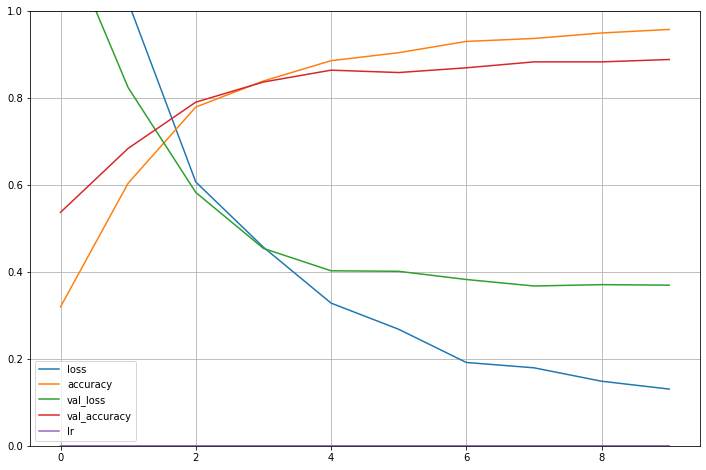

In [ ]:
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
_, accuracy = flower_model.evaluate(ds_test)

comp = comp.append({'model': 'unoptim_model', 'précision' : accuracy}, ignore_index=True)
print(comp)

12/12 [==============================] - 1s 62ms/step - loss: 0.3304 - accuracy: 0.8910
           model  précision
0  unoptim_model   0.891008


### Sauvegarde

Pour convertir un modèle, que ce soit avec TF Lite ou avec TensorRT, on doit le sauvegarder sous la format `SavedModel` qui est le format standard de TensorFlow. La méthode classique où l'on utilise le format `.h5` est elle propre à `tf.keras`.

In [ ]:
# Unoptimized (SavedModel format)
flower_model.save("base_model/flower_model_no_op")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: base_model/flower_model_no_op/assets


In [ ]:
# Check size
!du --all -h base_model/flower_model_no_op

4.0K	base_model/flower_model_no_op/assets
3.6M	base_model/flower_model_no_op/saved_model.pb
40K	base_model/flower_model_no_op/variables/variables.index
34M	base_model/flower_model_no_op/variables/variables.data-00000-of-00001
34M	base_model/flower_model_no_op/variables
37M	base_model/flower_model_no_op


Charger un modèle se fait de la même façon, que l'on utilise le format `SavedModel` ou `.h5`.

In [ ]:
flower_model = tf.keras.models.load_model('base_model/flower_model_no_op')

# Check its architecture
#flower_model.summary()

https://colab.research.google.com/gist/jvishnuvardhan/2cc844c7f00fec232d04af0a83d9bb22/untitled224.ipynb

## TensorFlow Lite, quantification

TensorFlow Lite est un ensemble d'outils permettant de faire tourner des modèles TensorFlow sur de "l'embarqué", ie du smartphone au microcontrôleur.

TensorFlow Lite possède deux composantes principales : 

  - TensorFlow Lite Converter, qui convertit les modèles en un format spécifique, un `FlatBuffer`, optimisé pour les déploiements dans les enrionnements contraints en terme de mémoire. Il applique aussi des techniques d'optimisations pour réduire encore la taille du modèle et accélérer sa vitesse d'inférence.
  - TensorFlow Lite Interpreter, qui permet de faire tourner les modèles convertis.

Une des optimisations là plus utilisée est la quantification. 

En général, nos modèles fonctionnent en format de précision float32. Tous les paramètres du modèle sont stockés dans ce format de précision, ce qui conduit souvent à des modèles plus lourds. La lourdeur d'un modèle est en corrélation directe avec la vitesse à laquelle le modèle fait des prédictions. Ainsi, il pourrait vous venir naturellement à l'esprit que si nous pouvions réduire la précision dans laquelle nos modèles fonctionnent, nous pourrions réduire les temps de prédiction. C'est ce que fait la quantification - elle réduit la précision à des formes plus basses comme float16, int8, etc. pour représenter les paramètres d'un modèle.

La quantification peut être appliquée à un modèle sous deux formes

- **La quantification post-entraînement** est appliquée à un modèle après sa formation.

- **Entraînement conscient de la quantification** : un modèle est généralement entraîné pour compenser la perte de précision qui pourrait être introduite en raison de la quantification. Lorsque vous réduisez la précision des paramètres de votre modèle, il peut en résulter une perte d'informations et vous pourriez constater une certaine réduction de la précision de votre modèle. Dans ces situations, une formation tenant compte de la quantification peut être très utile.



Pour installer uniquement l'interpréteur, ce que l'on fait en pratique sur la carte dédiée à l'inférence, soyez sûr de choisir le bon interpréteur en vérifiant sur :

https://www.tensorflow.org/lite/guide/python#run_an_inference_using_tflite_runtime

```python
!pip3 install https://dl.google.com/coral/python/tflite_runtime-2.1.0.post1-cp36-cp36m-linux_x86_64.whl

# Load the model into interpreters
import tflite_runtime.interpreter as tflite
```

#### Définition de fonction utiles

On va créer deux datasets :

  - Un premier classique, qui servira à évaluer les modèles `.tflite` pour voir leur précision.
  - Le deuxième lui est ce que l'on appelle un **dataset représentatif**, ce dataset servira durant la conversion pour aider à transformer au mieux les poids et les biais au format voulu. Idéalement, on essaye de prendre un sous ensemble du dataset de validation pour le créer.

**Evaluation Dataset**

Les modèles convertis et optimisés `.tflite` ne lisent pas les datasets au format `tf.data.Dataset`, qui sont spécalisés pour l'entraînement. On va donc faire un dataset de validation de façon classique sous la forme d'un tableau.

Les modèles `.tflite` sont optimisés pour des utilisation sur CPU unique, Colab ayant été mis en mode GPU/CPU en serveur pour les besoins de l'entraînement du modèle vous pourriez être surpris de voir que le temps de validation d'un modèle `.tflite` sera ici long, environ 1 image par seconde. Cela est dû à l'optimisation pour CPU, sur un Rapsberry pi, l'inférence est de l'ordre de la milliseconde.

In [ ]:
# Prepare validation sets
# Extract the image paths from the train set

# Empty labels for storing images and labels
val_images = []

# Iterate over the image paths
for image in flower_val:
    # Read the image from the current path, change the datatype, resize the image,
    # add batch dimension, normalize the pixel values
    image_pixels = plt.imread(image).astype("float32")
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = np.expand_dims(image_pixels, 0)
    image_pixels = image_pixels / 255.

    # Append to the list
    val_images.append(image_pixels)
    val_labels = label_val

# Create NumPy array
val_images = np.array(val_images)

Sanity Check

In [ ]:
print(f'val_images : {len(val_images)}, val_labels : {len(val_labels)}')

val_images : 367, val_labels : 367


**Dataset Représentatif**

In [ ]:
# Extract the image paths from the validation set, shuffle them, and 
# choose 100 images
flower_val2 = flower_val
random.shuffle(flower_val2)
image_paths = flower_val2[:100]

# An empty list as a placeholder for the dataset
rep_ds = []

# Iterate over the image paths
for image in image_paths:
  # Read the image from the current path, change the datatype, resize the image,
  # add batch dimension, normalize the pixel values
  image_pixels = plt.imread(image).astype("float32")
  image_pixels = cv2.resize(image_pixels, (224, 224))
  image_pixels = np.expand_dims(image_pixels, 0)
  image_pixels = image_pixels / 255.
  
  # Append to the list
  rep_ds.append(image_pixels)

# Convert to TensorFlow dataset
rep_ds = np.array(rep_ds)
rep_ds = tf.data.Dataset.from_tensor_slices((rep_ds))

# Creating a representative dataset for int quantization
def representative_dataset():
    for image in rep_ds.take(100):
        yield [image]

**Evaluation Function**

In [ ]:
# A helper function to evaluate the TF Lite model using "test" dataset.
# Comes from: https://www.tensorflow.org/lite/performance/post_training_integer_quant
def evaluate_model(interpreter):

  acc = tf.keras.metrics.Accuracy()

  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  predictions = []
  start_time = time.time()
  for val_image, val_label in zip(val_images, val_labels):
    interpreter.set_tensor(input_index, val_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    probability = interpreter.get_tensor(output_index)
    flower_id = np.argmax(probability[0])
    predictions.append(flower_id)
  
  print(f'{len(predictions)}, {len(val_labels)}')
  print(f'took {time.time()-start_time} seconds, ie {(time.time()-start_time)/len(val_images)} img/s')
  acc.update_state(val_labels, predictions)
  acc = acc.result().numpy()

  return acc

### Quantification du modèle non optimisé

In [ ]:
#create tflite_model folders
!mkdir tflite_model

mkdir: cannot create directory ‘tflite_model’: File exists


Vous commencez par charger votre modèle dans une classe de convertisseur TFLiteConverter, puis vous spécifiez une politique d'optimisation, et enfin, vous demandez à TFLite de convertir votre modèle avec la politique d'optimisation.

Cette forme de quantification est également appelée **quantification de la gamme dynamique post-formation**. Elle quantifie les poids de votre modèle avec une précision flottante de 8 bits.

In [ ]:
# Quantize `flower_model`
converter = tf.lite.TFLiteConverter.from_keras_model(flower_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
quantized_tflite_model = converter.convert()

f = open("tflite_model/normal_flower_model.tflite", "wb")
f.write(quantized_tflite_model)
f.close()

!ls -lh tflite_model/normal_flower_model.tflite

INFO:tensorflow:Assets written to: /tmp/tmpgtv1t3br/assets
-rw-r--r-- 1 root root 3.4M Aug 27 20:49 tflite_model/normal_flower_model.tflite


#### Evaluation

In [ ]:
# Load the model into interpreters
interpreter_nor = tf.lite.Interpreter(model_path="tflite_model/normal_flower_model.tflite")
interpreter_nor.allocate_tensors()

# Evaluate the performance
accuracy = evaluate_model(interpreter_nor)
print(accuracy)

367, 367
took 427.43566703796387 seconds, ie 1.1646749726433194 img/s
0.8882834


In [ ]:
comp = comp.append({'model': 'normal_quant_model', 'précision' : accuracy}, ignore_index=True)
print(comp)

                model  précision
0       unoptim_model   0.891008
1  normal_quant_model   0.888283


### Entraînement conscient de la quantification

Une bonne première approche consiste à entraîner votre modèle de manière à ce qu'il apprenne à compenser la perte d'informations qui pourrait être induite par la quantification. C'est précisément ce que nous pouvons faire avec un entraînement conscient de la quantification. Pour former notre réseau à la quantification, il suffit d'ajouter les lignes de code suivantes

**ATTENTION** : Les techniques d'entraînements conscients de la quantification sont encore relativement récentes, et si cela ne pose pas trop de problèmes pour la plupart des modèles, il est important de vérifier que les couches que l'on met le supporte.

https://www.tensorflow.org/model_optimization/guide/quantization/training#general_support_matrix

Par exemple : *BatchNormalization when it follows Conv2D and DepthwiseConv2D layers*.

Ce qui veut dire le modèle ResNet50 proposé par `tf.keras` supporte cet entraînement, car la brique de base est $\text{Conv-BN-ReLU}$, mais ResNet50V2, qui lui utilise l'architecture $\text{BN-ReLU-Conv}$ ne le supporte pas de façon native pour l'instant.

Pour pouvoir utiliser les méthodes de quantification durant l'entraînement, on va installer la librairie **TensorFlow Model Optimization**.

In [ ]:
!pip install -q tensorflow-model-optimization

In [ ]:
import tensorflow_model_optimization as tfmot

In [ ]:
# Let's reload the model and allow the model to be trained in a quantization-aware manner
flower_model = get_training_model()
q_flower_model = tfmot.quantization.keras.quantize_model(flower_model)
q_flower_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
quantize_layer (QuantizeLayer)  (None, 224, 224, 3)  3           input_1[0][0]                    
__________________________________________________________________________________________________
quant_Conv1_pad (QuantizeWrappe (None, 225, 225, 3)  1           quantize_layer[1][0]             
__________________________________________________________________________________________________
quant_Conv1 (QuantizeWrapper)   (None, 112, 112, 32) 929         quant_Conv1_pad[0][0]            
_______________________________________________________________________________________

In [ ]:
# Train the model
q_flower_model.compile(loss="categorical_crossentropy", 
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=["accuracy"])
start = time.time()
history = q_flower_model.fit(ds_train,
                             validation_data=ds_val,
                             epochs=10,
                             callbacks=[lr_callback])
print("Total training time: ",time.time()-start)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/10
92/92 [==============================] - 48s 525ms/step - loss: 1.3237 - accuracy: 0.4608 - val_loss: 1.1802 - val_accuracy: 0.5286

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
Epoch 2/10
92/92 [==============================] - 47s 506ms/step - loss: 0.6181 - accuracy: 0.7841 - val_loss: 0.7309 - val_accuracy: 0.7248

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 3/10
92/92 [==============================] - 47s 507ms/step - loss: 0.3348 - accuracy: 0.8866 - val_loss: 0.4900 - val_accuracy: 0.8174

Epoch 00004: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
Epoch 4/10
92/92 [==============================] - 47s 508ms/step - loss: 0.2310 - accuracy: 0.9244 - val_loss: 0.3889 - val_accuracy: 0.8774

Epoch 00005: LearningRateScheduler reducing learning rate to 4.2000000000000004e-05.
Epoch 5/10
92/9

In [ ]:
# Serializing the model and seeing the size of it
q_flower_model.save("base_model/q_flower_model")
!ls -lh base_model/q_flower_model

INFO:tensorflow:Assets written to: base_model/q_flower_model/assets


INFO:tensorflow:Assets written to: base_model/q_flower_model/assets


total 7.6M
drwxr-xr-x 2 root root 4.0K Aug 27 19:14 assets
-rw-r--r-- 1 root root 7.6M Aug 27 21:07 saved_model.pb
drwxr-xr-x 2 root root 4.0K Aug 27 21:07 variables


### Optimisation TFLite et évaluation

#### Quantification du modèle QAT avec la politique `tf.lite.Optimize.DEFAULT`

In [ ]:
# Quantize `q_flower_model` (this one was trained with QAT)
converter = tf.lite.TFLiteConverter.from_keras_model(q_flower_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()
f = open("tflite_model/qat_flower_model.tflite", "wb")
f.write(quantized_tflite_model)
f.close()

INFO:tensorflow:Assets written to: /tmp/tmpdukvh87r/assets


INFO:tensorflow:Assets written to: /tmp/tmpdukvh87r/assets


In [ ]:
# Size of this model
!ls -lh tflite_model/qat_flower_model.tflite

-rw-r--r-- 1 root root 3.3M Aug 27 21:08 tflite_model/qat_flower_model.tflite


##### Evaluation

In [ ]:
# Load the model into interpreters
interpreter_qat = tf.lite.Interpreter(model_path="tflite_model/qat_flower_model.tflite")
interpreter_qat.allocate_tensors()

# Check
accuracy = evaluate_model(interpreter_qat)

comp = comp.append({'model': 'qat_model', 'précision' : accuracy}, ignore_index=True)
print(comp)

367, 367
took 421.8337481021881 seconds, ie 1.1494109019921326 img/s
                model  précision
0       unoptim_model   0.891008
1  normal_quant_model   0.888283
2           qat_model   0.923706


#### Quantification du modèle QAT avec la politique `tf.lite.Optimize.OPTIMIZE_FOR_LATENCY`

In [ ]:
# Quantize `q_flower_model` for latency
converter = tf.lite.TFLiteConverter.from_keras_model(q_flower_model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
quantized_tflite_model = converter.convert()
f = open("tflite_model/flower_model_latency.tflite", "wb")
f.write(quantized_tflite_model)
f.close()

!ls -lh tflite_model/flower_model_latency.tflite

INFO:tensorflow:Assets written to: /tmp/tmpsspdtrid/assets


INFO:tensorflow:Assets written to: /tmp/tmpsspdtrid/assets


-rw-r--r-- 1 root root 3.3M Aug 27 19:27 tflite_model/flower_model_latency.tflite


##### Evaluation

In [ ]:
# Load the model into interpreters
interpreter_qat = tf.lite.Interpreter(model_path="tflite_model/flower_model_latency.tflite")
interpreter_qat.allocate_tensors()

# Check
accuracy = evaluate_model(interpreter_qat)

comp = comp.append({'model': 'qat_model_latency', 'précision' : accuracy}, ignore_index=True)
print(comp)

100, 100
took 116.97213435173035 seconds, ie 1.1697216296195985 img/s
               model  précision
0          qat_model       0.86
1  qat_model_latency       0.86


#### Quantification du modèle QAT avec la politique `tf.lite.Optimize.OPTIMIZE_FOR_SIZE`

In [ ]:
# Quantize `q_flower_model` for size
converter = tf.lite.TFLiteConverter.from_keras_model(q_flower_model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
quantized_tflite_model = converter.convert()
f = open("tflite_model/flower_model_size.tflite", "wb")
f.write(quantized_tflite_model)
f.close()

!ls -lh tflite_model/flower_model_size.tflite

INFO:tensorflow:Assets written to: /tmp/tmpbxstisro/assets


INFO:tensorflow:Assets written to: /tmp/tmpbxstisro/assets


-rw-r--r-- 1 root root 3.3M Aug 27 19:31 tflite_model/flower_model_size.tflite


##### Evaluation

In [ ]:
# Load the model into interpreters
interpreter_nor = tf.lite.Interpreter(model_path="tflite_model/flower_model_size.tflite")
interpreter_nor.allocate_tensors()

# Check
accuracy = evaluate_model(interpreter_qat)

comp = comp.append({'model': 'qat_model_size', 'précision' : accuracy}, ignore_index=True)
print(comp)

100, 100
took 116.84006810188293 seconds, ie 1.168400981426239 img/s
               model  précision
0          qat_model       0.86
1  qat_model_latency       0.86
2     qat_model_size       0.86


### Quantification complète int8

TensorFlow Lite supporte la conversion de toutes les valeurs du modèle (poids et activations) en entiers 8bits. Cela permet de réduire la taille du modèle par un facteur 4 et améliorer ses performances CPU par un facteur 3-4.

**ATTENTION** : Cette méthode d'entraînement n'est pas pour l'instant pas déstinée aux RaspberryPi, mais aux accélérateurs propriétaires de Google tels que la *Google Coral*, *Coral TPU*, et aux microcontrôleurs électroniques compatibles.

Cette méthode de quantification est dite **post-entraînement**, le modèle a besoin d'être entraîné de façon classique avant qu'il puisse être optimisé.

In [ ]:
# TF Lite conversion 
# Creating integer only models is a common use case for TensorFlow Lite for Microcontrollers and Coral Edge TPUs.
# Instantiate the converter, instruct TF Lite to optimize for size, and
# specify the representative dataset
converter = tf.lite.TFLiteConverter.from_keras_model(flower_model) 
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE] 
converter.representative_dataset = representative_dataset

# We are going for full INT8 quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

# Convert finally
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpay6fpaw2/assets


INFO:tensorflow:Assets written to: /tmp/tmpay6fpaw2/assets


In [ ]:
# Serialize the TFLite model and check it's size
f = open("tflite_model/int8_flower_model.tflite", "wb")
f.write(tflite_model)
f.close()

!du --all -h tflite_model/int8_flower_model.tflite

3.4M	tflite_model/int8_flower_model.tflite


On est passé d'un modèle de $38$Mo à un modèle optimisé en entiers $8$bits de $3,4$Mo.

In [ ]:
interpreter_quant = tf.lite.Interpreter(model_content=tflite_model)
interpreter_quant.allocate_tensors()
input_index_quant = interpreter_quant.get_input_details()[0]["index"]
output_index_quant = interpreter_quant.get_output_details()[0]["index"]

#### Evaluation

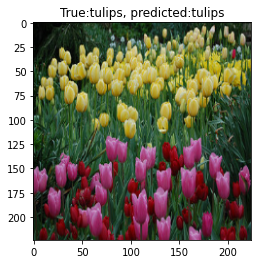

In [ ]:
# Run a demo prediction
i= 30

CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

image_int8 = plt.imread(flower_val[:100][i])
image_int8 = cv2.resize(image_int8, (224, 224))
image_int8 = np.expand_dims(image_int8, 0)

interpreter_quant.set_tensor(input_index_quant, image_int8)
interpreter_quant.invoke()
predictions = interpreter_quant.get_tensor(output_index_quant)

# See the prediction
plt.imshow(image_int8.squeeze())
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true=CLASSES[val_labels[i]],
                              predict=str(CLASSES[np.argmax(predictions[0])])))
plt.grid(False)

In [ ]:
# Prepare validation sets
# Extract the image paths from the train set

# Empty labels for storing images and labels
val_images_int8 = []

# Iterate over the image paths
for image in flower_val[:100]:
    # Read the image from the current path, change the datatype, resize the image,
    # add batch dimension, normalize the pixel values
    image_pixels = plt.imread(image)
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = np.expand_dims(image_pixels, 0)

    # Append to the list
    val_images_int8.append(image_pixels)
    val_labels_int8 = label_val[:100]

# Create NumPy array
val_images_int8 = np.array(val_images_int8)

In [ ]:
# A helper function to evaluate the TF Lite model using "test" dataset.
# Comes from: https://www.tensorflow.org/lite/performance/post_training_integer_quant
def evaluate_model_int8(interpreter):

  acc = tf.keras.metrics.Accuracy()

  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  predictions = []
  start_time = time.time()
  for val_image, val_label in zip(val_images_int8, val_labels_int8):
    interpreter.set_tensor(input_index, val_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    probability = interpreter.get_tensor(output_index)
    flower_id = np.argmax(probability[0])
    predictions.append(flower_id)
  
  print(f'{len(predictions)}, {len(val_labels)}')
  print(f'took {time.time()-start_time} seconds, ie {(time.time()-start_time)/len(val_images)} img/s')
  acc.update_state(val_labels, predictions)
  acc = acc.result().numpy()

  return acc

In [ ]:
# Check
accuracy = evaluate_model_int8(interpreter_quant)
print(accuracy)
#comp = comp.append({'model': 'int8_model', 'précision' : accuracy}, ignore_index=True)
#print(comp)

100, 100
took 116.83910274505615 seconds, ie 1.1683917617797852 img/s
0.3


### Quantification du modèle QAT fp16

In [ ]:
# Quantize `q_flower_model` with fp16 policy (float)
converter = tf.lite.TFLiteConverter.from_keras_model(q_flower_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

quantized_tflite_model = converter.convert()
f = open("tflite_model/flower_model_fp16.tflite", "wb")
f.write(quantized_tflite_model)
f.close()

!ls -lh tflite_model/flower_model_fp16.tflite

INFO:tensorflow:Assets written to: /tmp/tmpnjlf_rpq/assets


INFO:tensorflow:Assets written to: /tmp/tmpnjlf_rpq/assets


-rw-r--r-- 1 root root 11M Aug 27 19:58 tflite_model/flower_model_fp16.tflite


##### Evaluation

In [ ]:
# Load the model into interpreters
interpreter_fp16 = tf.lite.Interpreter(model_path="tflite_model/flower_model_fp16.tflite")
interpreter_fp16.allocate_tensors()

accuracy = evaluate_model(interpreter_fp16)

comp = comp.append({'model': 'nopol_model', 'précision' : accuracy}, ignore_index=True)
print(comp)

RuntimeError: ignored

tensorflow/lite/kernels/quantize.cc:111 affine_quantization->scale->size == 1 was not true.Node number 0 (QUANTIZE) failed to prepare.


 have this problem as well (tf 2.3.0 - did not occur with 2.2.0). It occurs when quantizing an imagenet pretrained mobilenetv2 using target_spec=tf.float16 quantization. target_spec=int8 quantization works well in the same setup though.

Original Error:
"RuntimeError: tensorflow/lite/kernels/quantize.cc:111 affine_quantization->scale->size == 1 was not true.Node "number 2 (QUANTIZE) failed to prepare.

It occurs when mobilenetv2s bn_Conv1 layer is quantized.

https://github.com/tensorflow/tensorflow/issues/41308

https://github.com/tensorflow/model-optimization/issues/412